# Постановка задачи

## Предсказание цен на недвижимость

### Description

Участникам предоставлен набор данных объявлений о продаже недвижимости в некотором волшебном городе N. Задача - предсказать цену недвижимости по содержанию объявления.

### Evaluation

Метрика данного соревнования mean absolute error [MAE]

Балл рассчитывается как обратная величина метрике: $score=\frac{1}{1+MAE}$

Разбиение на Train/Test выполнено по времени объявления.
Разбиение тестового набора на Public/Private выполнено случайным образом в пропорции 30/70% соответственно.

## Подключание окружения

### pip

In [3]:
!pip install pandas numpy seaborn matplotlib scipy scikit-learn xgboost catboost progressbar2 hyperopt keras tensorflow

### import

In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
import timeit
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("darkgrid")

from progressbar import progressbar
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

In [7]:
mae = lambda y_true, y_pred: ( 1 / ( 1 + mean_absolute_error(y_true, y_pred) ) )

In [8]:
def getDataMeanInfo(df):
    '''
    Метод возвращает данные для усреднения
    '''
    n_data = df.select_dtypes([np.number])
    n_data_mean = n_data.mean()
    n_features = n_data.columns
    return n_data, n_data_mean, n_features

In [9]:
def plotWeightsScales(features, weights, scales, title=None):
    fig, axs = plt.subplots(figsize=(21, 9), ncols=2)
    sns.barplot(y=num_features, x=weights, ax=axs[0], palette ='coolwarm')
    axs[0].set_title( ( '' if title == None else title[0] ) )
    axs[0].set(xlabel='weights', ylabel='')
    sns.barplot(y=num_features, x=scales, ax=axs[1], palette ='coolwarm')
    axs[1].set_title( ( '' if title == None else title[1] ) )
    axs[1].set(xlabel='scales', ylabel='')
    plt.show()

# Подготовка данных

## Извлечение данных

In [10]:
X = pd.read_csv("Train.csv", index_col="id")
X.shape

(100000, 24)

In [11]:
X

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2012-3,401,0.0,5,30,1,0,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,1697000
99996,2012-3,59,0.0,4,34,1,0,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,3620000
99997,2012-3,253,NaN,3,52,2,0,5.0,NaN,4,...,0,0,0,0,0,0,0,0,0,6712000


Извлечем в *y* переменную данные из колонки price. колонку *date* удалим

In [12]:
del X['date']

## Анализ данных

Выведем информаци

In [13]:
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
street_id,100000.0,3.344793e+02,1.940048e+02,0.0,167.0,334.0,501.0,671.0
build_tech,70265.0,5.298370e-01,5.736453e-01,0.0,0.0,0.0,1.0,2.0
floor,100000.0,5.267680e+00,3.905558e+00,1.0,2.0,4.0,7.0,25.0
area,100000.0,5.225343e+01,1.779250e+01,29.0,40.0,52.0,60.0,217.0
rooms,100000.0,2.118680e+00,8.296879e-01,1.0,1.0,2.0,3.0,6.0
balcon,100000.0,3.967400e-01,5.476316e-01,0.0,0.0,0.0,1.0,2.0
metro_dist,95104.0,2.215443e+01,8.286241e+00,0.0,15.0,25.0,30.0,30.0
g_lift,70008.0,5.009856e-01,5.000026e-01,0.0,0.0,1.0,1.0,1.0
n_photos,100000.0,2.470910e+00,1.944981e+00,0.0,1.0,2.0,4.0,11.0
kw1,100000.0,5.565000e-02,2.292457e-01,0.0,0.0,0.0,0.0,1.0


In [14]:
X_describe_copy = X.copy()

In [15]:
y = X['price'].copy()
del X['price']
y

id
0         4510000
1        13231000
2         2008000
3        12680000
4         3335000
           ...   
99995     1697000
99996     3620000
99997     6712000
99998    20835000
99999     2909000
Name: price, Length: 100000, dtype: int64

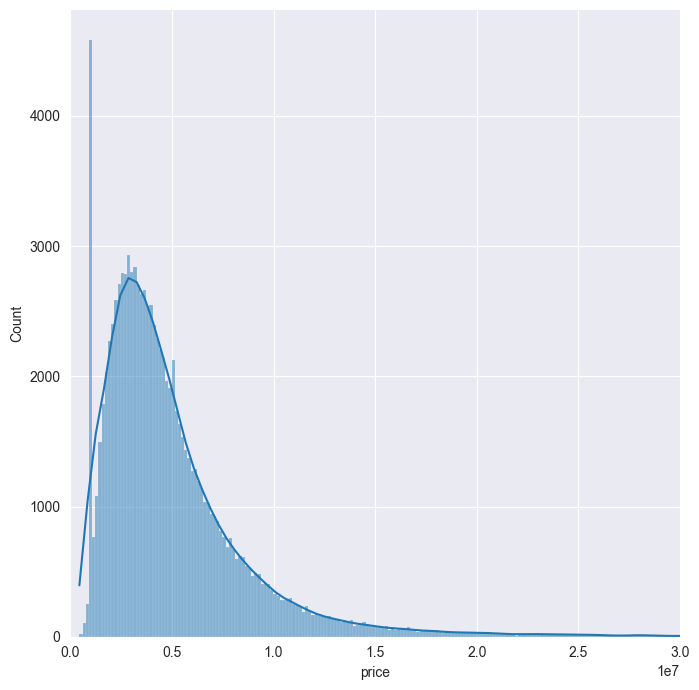

In [16]:
sns.set_style("darkgrid")
sns.displot(y, kde=True, height=7)
plt.xlim(0, 3e7)
plt.show()

In [17]:
num_data, num_data_mean, num_features = getDataMeanInfo(X)

In [18]:
X = X.fillna(num_data_mean)

correlation = X[num_features].corrwith(y).sort_values(ascending=False)

In [19]:
X_describe_copy.describe(include='all')[['build_tech', 'metro_dist', 'g_lift']].T

,count,mean,std,min,25%,50%,75%,max
build_tech,70265.0,0.529837,0.573645,0.0,0.0,0.0,1.0,2.0
metro_dist,95104.0,22.154431,8.286241,0.0,15.0,25.0,30.0,30.0
g_lift,70008.0,0.500986,0.500003,0.0,0.0,1.0,1.0,1.0


In [20]:
X.describe(include='all')[['build_tech', 'metro_dist', 'g_lift']].T

,count,mean,std,min,25%,50%,75%,max
build_tech,100000.0,0.529837,0.480853,0.0,0.0,0.529837,1.0,2.0
metro_dist,100000.0,22.154431,8.080847,0.0,15.0,25.000000,30.0,30.0
g_lift,100000.0,0.500986,0.418355,0.0,0.0,0.500986,1.0,1.0


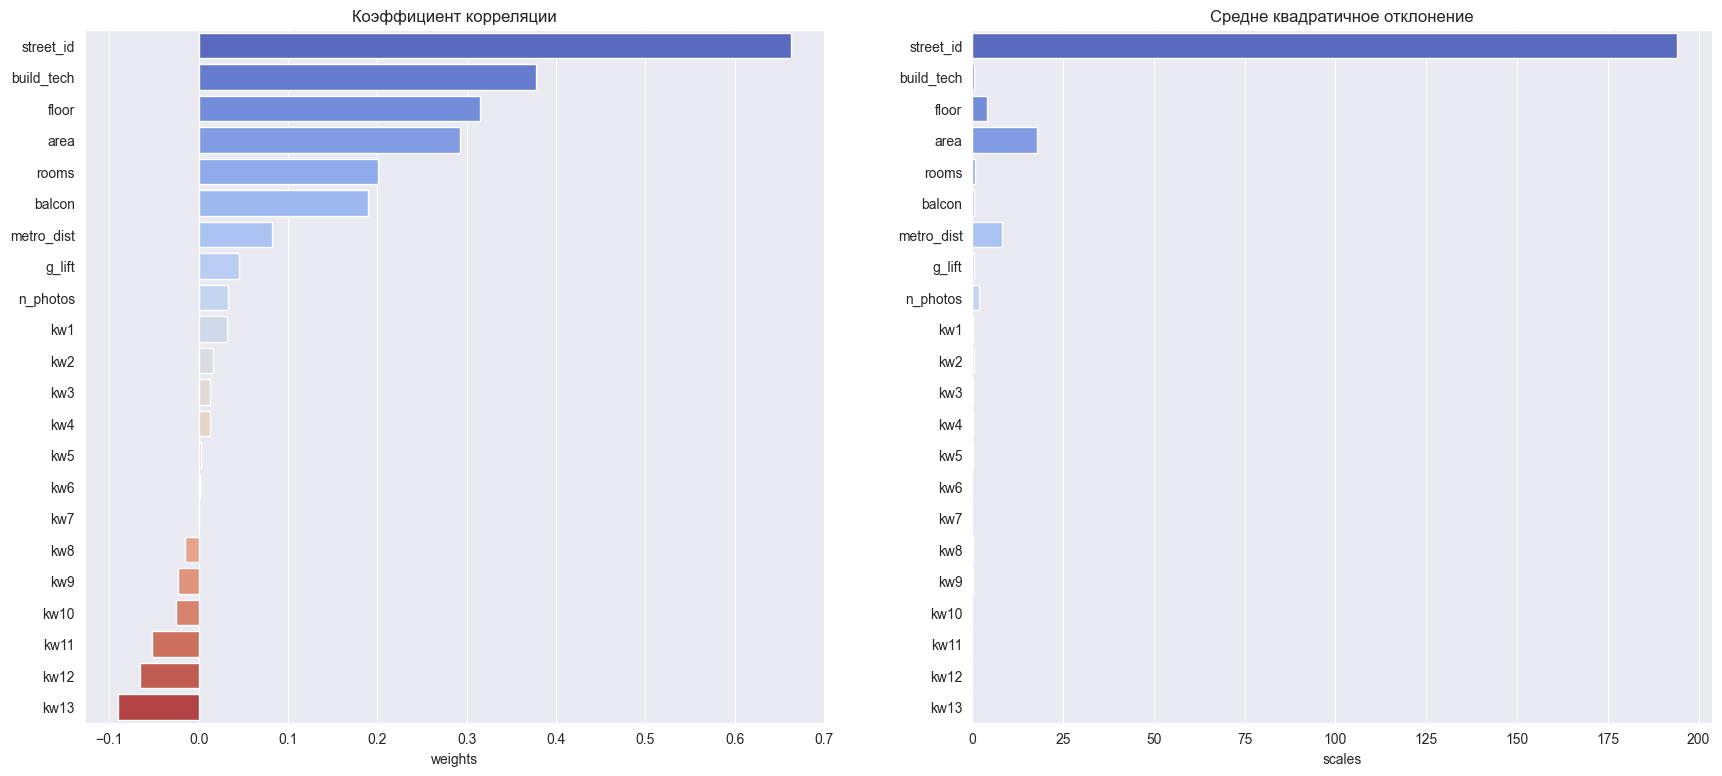

In [21]:
plotWeightsScales(num_features, correlation, X[num_features].std(), ('Коэффициент корреляции', 'Средне квадратичное отклонение'))

## Данные

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling

## Полезные функции

In [127]:
def pipeLine(model):
    column_transformer = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_features),
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

In [29]:
def printMAE(model, title, X_t=X_train, X_v=X_val, y_t=y_train, y_v=y_val):
    model.fit(X_t, y_t)
    y_pred = model.predict(X_v)
    print(f'{title} MAE: {np.round(mean_absolute_error(y_pred, y_v), 3)}')
    return model

## ensemble

Для начала проверим модели из раздела ensemble

In [287]:
if_model = IsolationForest()
printMAE(if_model, "IsolationForest")

IsolationForest MAE: 5152285.74


IsolationForest()

In [285]:
etr_model = ExtraTreesRegressor()
printMAE(etr_model, "ExtraTreesRegressor")

ExtraTreesRegressor MAE: 1929534.798


ExtraTreesRegressor()

In [331]:
%%time
gbr_model = GradientBoostingRegressor()
printMAE(gbr_model, "GradientBoostingRegressor")

GradientBoostingRegressor MAE: 1740371.105
CPU times: user 5.26 s, sys: 31.3 ms, total: 5.29 s
Wall time: 5.33 s


GradientBoostingRegressor()

In [286]:
br_model = BaggingRegressor()
printMAE(br_model, "BaggingRegressor")

BaggingRegressor MAE: 1700391.405


BaggingRegressor()

In [284]:
rfr_model = RandomForestRegressor()
printMAE(rfr_model, "RandomForestRegressor")

RandomForestRegressor MAE: 1600669.753


RandomForestRegressor()

In [283]:
hgbr_model = HistGradientBoostingRegressor()
printMAE(hgbr_model, "HistGradientBoostingRegressor")

HistGradientBoostingRegressor MAE: 1594143.729


HistGradientBoostingRegressor()

### GradientBoostingRegressor

Обучение через *GridSearchCV* **слишком** долгим выходит даже на локальной машине, по этому было решено руками подобрать параметр, методом научного тыка.

In [24]:
gbr_learning_rates = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]
gbr_mae_learninig_rates = []
for lr in progressbar(gbr_learning_rates):
    buffer_model = GradientBoostingRegressor(loss='squared_error', criterion='squared_error',
                                             learning_rate=lr, n_estimators=400, verbose=0).fit(X_train, y_train)
    gbr_mae_learninig_rates.append(np.round(mean_absolute_error(buffer_model.predict(X_val), y_val), 3))

gbr_best_learninig_rates = gbr_learning_rates[gbr_mae_learninig_rates.index(min(gbr_mae_learninig_rates))]
print(f'Best {gbr_best_learninig_rates} with MAE: {min(gbr_mae_learninig_rates)}')

100% (10 of 10) |########################| Elapsed Time: 0:03:27 Time:  0:03:270:20


Best 0.8 with MAE: 955436.854


In [25]:
gbr_n_estimators_list = np.arange(100, 1500, 100)
gbr_mae_n_estimators_rates = []
for ne in progressbar(gbr_n_estimators_list):
    buffer_model = GradientBoostingRegressor(loss='squared_error', criterion='squared_error',
                                             learning_rate=gbr_best_learninig_rates, n_estimators=ne).fit(X_train, y_train)
    gbr_mae_n_estimators_rates.append(np.round(mean_absolute_error(buffer_model.predict(X_val), y_val), 3))

gbr_best_n_estimators = gbr_n_estimators_list[gbr_mae_n_estimators_rates.index(min(gbr_mae_n_estimators_rates))]
print(f'Best {gbr_best_n_estimators} with MAE: {min(gbr_mae_n_estimators_rates)}')

100% (14 of 14) |########################| Elapsed Time: 0:09:07 Time:  0:09:073607


Best 1400 with MAE: 899421.526


In [26]:
gbr_tol_list = np.arange(5e-5, 2e-4, 1e-5)
gbr_mae_tol_rates = []
for tl in progressbar(gbr_tol_list):
    buffer_model = GradientBoostingRegressor(loss='squared_error', criterion='squared_error',
                                             learning_rate=gbr_best_learninig_rates, n_estimators=gbr_best_n_estimators,
                                             tol=tl).fit(X_train, y_train)
    gbr_mae_tol_rates.append(np.round(mean_absolute_error(buffer_model.predict(X_val), y_val), 3))

gbr_best_tol = gbr_tol_list[gbr_mae_tol_rates.index(min(gbr_mae_tol_rates))]
print(f'Best {gbr_best_tol} with MAE: {min(gbr_mae_tol_rates)}')

100% (15 of 15) |########################| Elapsed Time: 0:18:02 Time:  0:18:021224


Best 0.00018999999999999998 with MAE: 898624.703


По итогу лучшая модель будет

In [27]:
gbr_best_model = GradientBoostingRegressor(loss='squared_error', criterion='squared_error',
                                           learning_rate=gbr_best_learninig_rates, n_estimators=gbr_best_n_estimators,
                                           tol=gbr_best_tol)

In [30]:
gbr_best_model = printMAE(gbr_best_model, "GradientBoostingRegressor best model")

GradientBoostingRegressor best model MAE: 899699.928


Пока что лучший результат

### HistGradientBoostingRegressor

In [293]:
loss_list = [ 'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile' ]
mae_loss_rates = []

for ll in progressbar(loss_list):
    if ll != 'quantile':
        model = HistGradientBoostingRegressor(loss=ll).fit(X_train, y_train)
        mae_loss_rates.append(np.round(mean_absolute_error(model.predict(X_val), y_val), 3))
    else:
        model = HistGradientBoostingRegressor(loss=ll, quantile=0.5).fit(X_train, y_train)
        mae_loss_rates.append(np.round(mean_absolute_error(model.predict(X_val), y_val), 3))

best_loss = loss_list[mae_loss_rates.index(min(mae_loss_rates))]
print(f'Best {best_loss} with MAE: {min(mae_loss_rates)}')

100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:070:01


Best poisson with MAE: 1542206.24


In [295]:
learning_rate_list = np.arange(0.1, 2.1, 0.1)
mae_learning_rate_rates = []

for lr in progressbar(learning_rate_list):
    model = HistGradientBoostingRegressor(loss=best_loss, learning_rate=lr).fit(X_train, y_train)
    mae_learning_rate_rates.append(np.round(mean_absolute_error(model.predict(X_val), y_val), 3))

best_learning_rate = learning_rate_list[mae_learning_rate_rates.index(min(mae_learning_rate_rates))]
print(f'Best {best_learning_rate} with MAE: {min(mae_learning_rate_rates)}')

100% (20 of 20) |########################| Elapsed Time: 0:00:16 Time:  0:00:160001


Best 0.4 with MAE: 1441622.806


In [296]:
max_iter_list = np.arange(100, 1100, 100)
mae_max_iter_rates = []

for mi in progressbar(max_iter_list):
    model = HistGradientBoostingRegressor(loss=best_loss, learning_rate=best_learning_rate, max_iter=mi ).fit(X_train, y_train)
    mae_max_iter_rates.append(np.round(mean_absolute_error(model.predict(X_val), y_val), 3))

best_max_iter = max_iter_list[mae_max_iter_rates.index(min(mae_max_iter_rates))]
print(f'Best {best_max_iter} with MAE: {min(mae_max_iter_rates)}')

100% (10 of 10) |########################| Elapsed Time: 0:00:15 Time:  0:00:150:01


Best 700 with MAE: 1411824.829


## LinearRegression

### Без параметров

In [98]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [99]:
lr_y_pred = lr_model.predict(X_val)
print(f'LinearRegression MAE: {np.round(mean_absolute_error(lr_y_pred, y_val), 3)}')

LinearRegression MAE: 1856775.662


### Проверим со StandarScaler

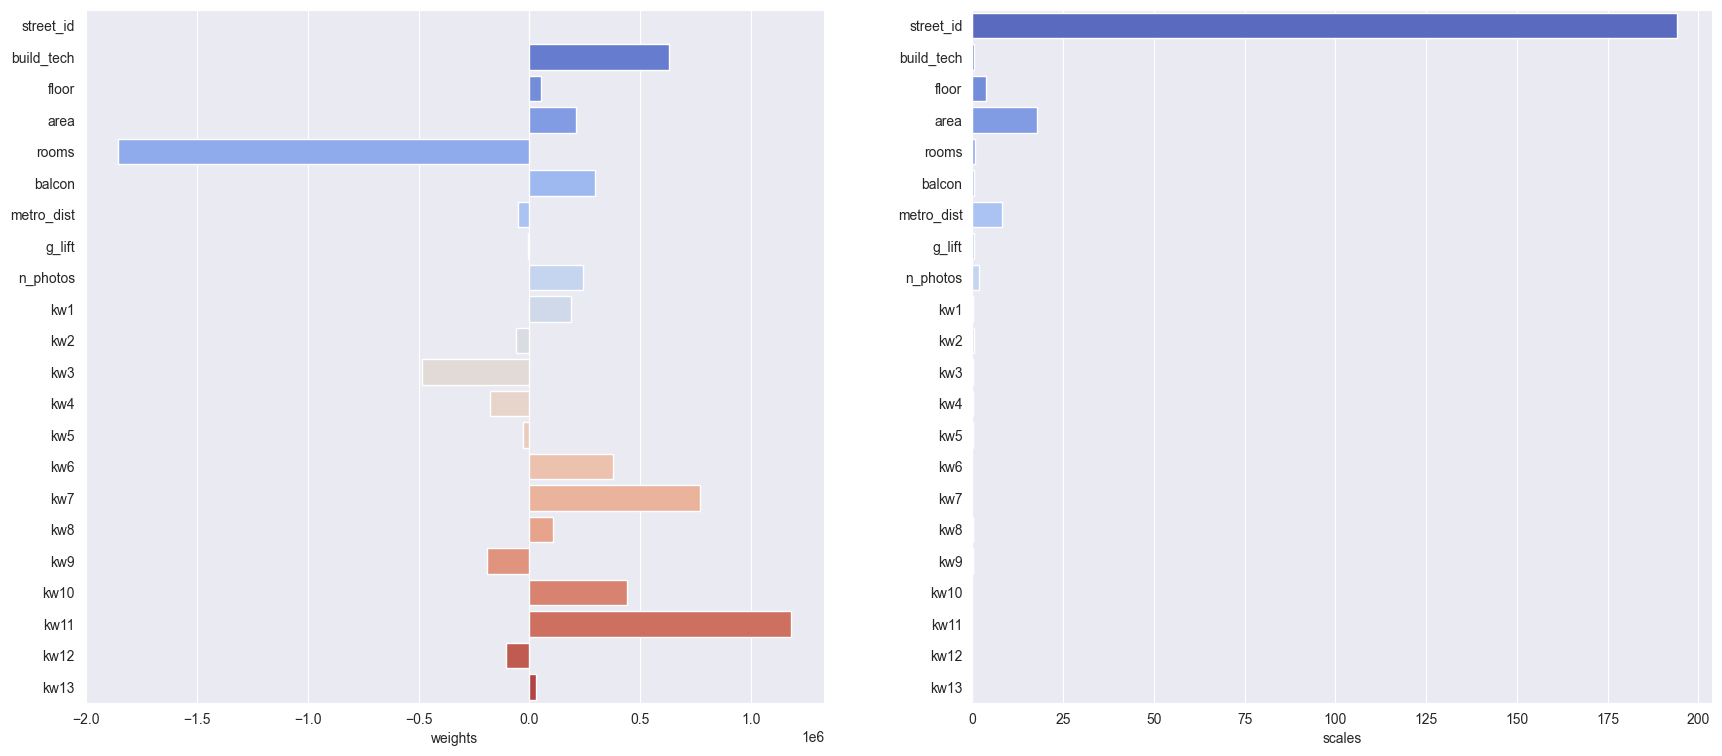

In [101]:
plotWeightsScales(num_features, lr_model.coef_, X_train[num_features].std())

In [109]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])
X_val_scaled = scaler.transform(X_val[num_features])

lr_scaler_model = LinearRegression()
lr_scaler_model.fit(X_train_scaled, y_train)
lr_scaler_y_pred = lr_scaler_model.predict(X_val_scaled)

print(f'LinearRegression scaler Test MAE: {np.round(mean_absolute_error(lr_scaler_y_pred, y_val), 3)}')

LinearRegression scaler Test MAE: 1856775.662


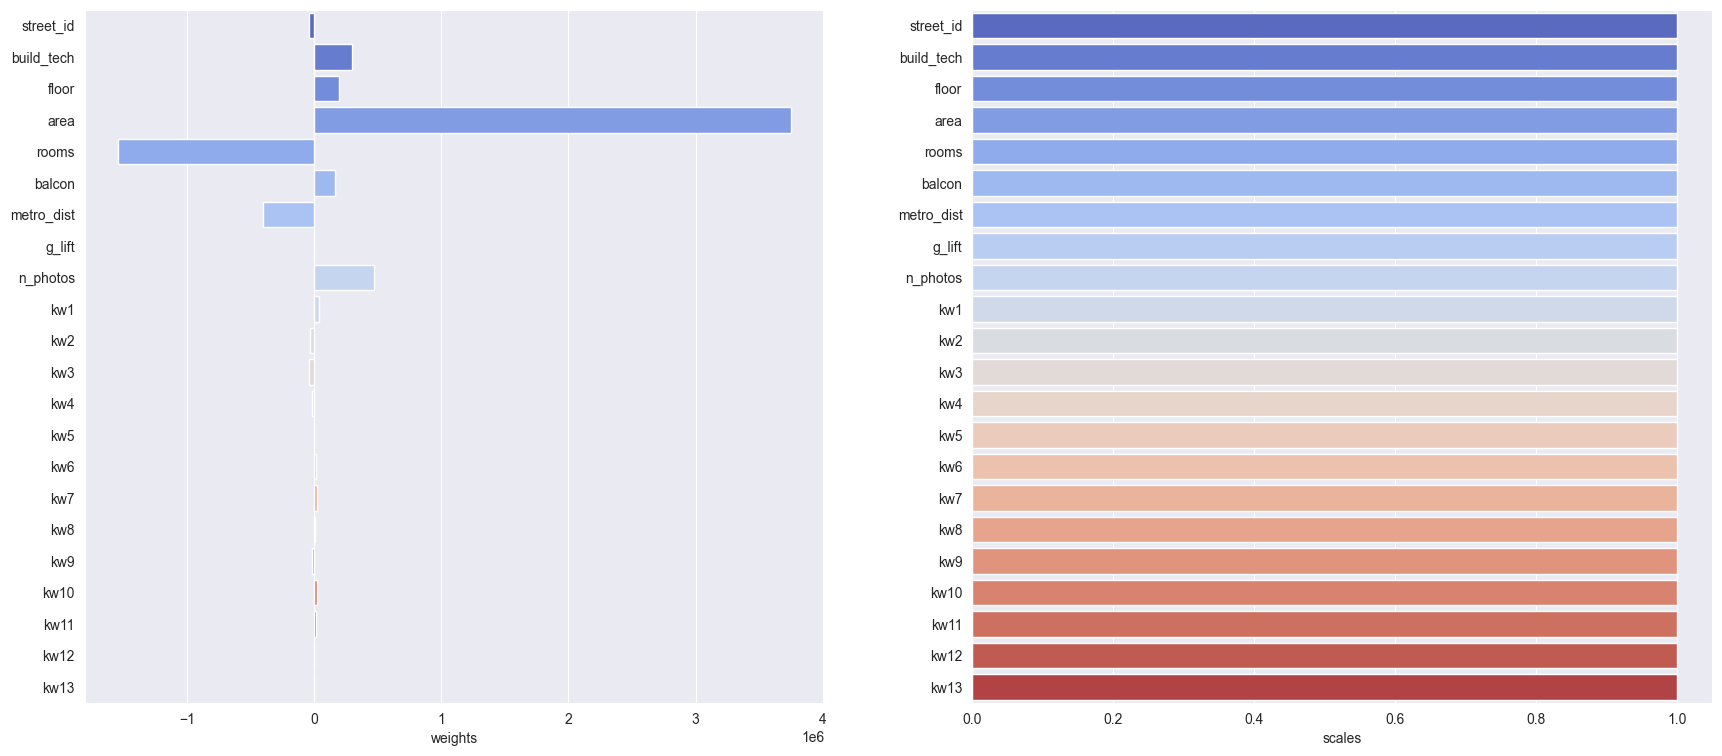

In [110]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=num_features)
plotWeightsScales(num_features, lr_scaler_model.coef_, scales)

### pipeLine

In [128]:
lr_pipe_model = pipeLine(LinearRegression())
lr_pipe_model = printMAE(lr_pipe_model, "LinearRegression")

LinearRegression MAE: 1856775.662


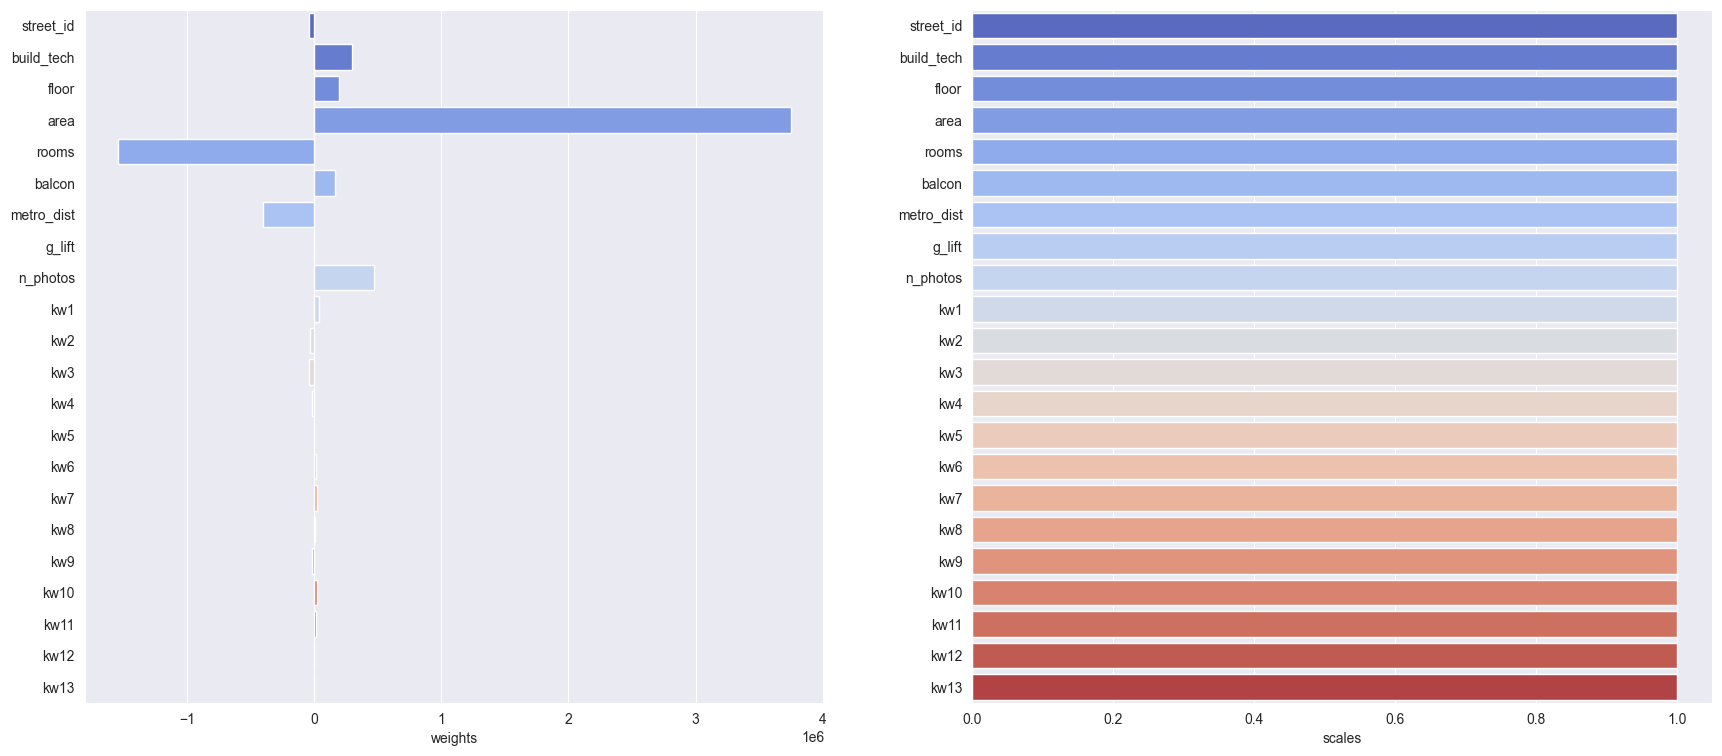

In [129]:
plotWeightsScales(num_features, lr_scaler_model.coef_, scales)

## XGBRegressor

In [146]:
xgb_pipe_model = pipeLine(XGBRegressor())
xgb_pipe_model = printMAE(xgb_pipe_model, "XGBRegressor PipeLine")

XGBRegressor PipeLine MAE: 1459148.274


In [147]:
xgb_model = XGBRegressor()
xgb_model = printMAE(xgb_model, "XGBRegressor")

XGBRegressor MAE: 1459148.274


## GradientBoostingRegressor

In [149]:
gbr_pipe_model = pipeLine(GradientBoostingRegressor())
gbr_pipe_model = printMAE(gbr_pipe_model, "GradientBoostingRegressor PipeLine")

GradientBoostingRegressor PipeLine MAE: 1740371.105


In [153]:
gbr_model = GradientBoostingRegressor()
gbr_model = printMAE(gbr_model, "GradientBoostingRegressor")

GradientBoostingRegressor MAE: 1740371.105


In [154]:
gbr_param_1_model = GradientBoostingRegressor(learning_rate=0.2, n_estimators=400)
gbr_param_1_model = printMAE(gbr_param_1_model, "GradientBoostingRegressor param 1")

GradientBoostingRegressor param 1 MAE: 1262518.754


## Lasso & Ridge

In [262]:
lasso_model = Lasso()
printMAE(lasso_model, "Lasso")

Lasso MAE: 1856775.564


Lasso()

In [260]:
ridge_model = Ridge()
printMAE(ridge_model, "Ridge")

Ridge MAE: 1856776.229


Ridge()

## Нейроная сеть

In [18]:
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [19]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [21]:
x_train = np.array(X_train)
x_train
Y_train = np.array(y_train)

In [22]:
model.fit(x_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step - loss: 4483738.5000
Epoch 2/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step - loss: 2843453.2500
Epoch 3/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step - loss: 2541957.0000
Epoch 4/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - loss: 2222880.2500
Epoch 5/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - loss: 2157264.5000
Epoch 6/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - loss: 2114359.5000
Epoch 7/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - loss: 2084272.2500
Epoch 8/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step - loss: 2049116.1250
Epoch 9/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step - loss: 2048251.5000
Epoch 10/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step - loss: 2015768.1250
Epoch 11/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - loss: 1989970.3750
Epoch 12/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step - loss: 1968190.7500
Epoch 13/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 327us/step - loss: 1998525.

In [25]:
predictions = model.predict(X_val)

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


In [26]:
print(f'MAE: {np.round(mean_absolute_error(predictions, y_val), 3)}')

MAE: 1901171.213


# Вывод

In [31]:
df_test = pd.read_csv("Test.csv")
X_test = df_test.copy()
del X_test["id"]
del X_test["date"]

In [32]:
num_data_test, num_data_mean_test, num_features_test = getDataMeanInfo(X_test)
X_test = X_test.fillna(num_data_mean)

In [33]:
X_test

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,459,0.529837,1,60,3,1,30.000000,0.000000,4,0,...,0,0,0,0,0,0,0,0,0,0
1,344,1.000000,10,52,2,1,22.154431,0.500986,4,0,...,0,0,0,0,0,0,0,0,0,0
2,585,0.000000,4,54,3,0,30.000000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,494,0.529837,2,52,2,1,25.000000,1.000000,3,0,...,0,0,0,0,0,0,0,0,0,0
4,622,1.000000,9,60,3,1,15.000000,0.500986,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,613,1.000000,2,34,1,1,25.000000,0.500986,2,0,...,0,0,0,0,0,0,0,0,0,0
99996,167,1.000000,10,61,3,1,30.000000,0.500986,4,0,...,0,0,0,0,0,0,0,0,0,0
99997,391,1.000000,9,34,1,1,30.000000,0.500986,3,0,...,0,0,0,0,0,0,0,0,0,0
99998,21,0.000000,7,58,3,0,30.000000,0.000000,3,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
street_id,100000.0,334.758430,193.831614,0.0,166.0,334.000000,502.0,671.0
build_tech,100000.0,0.531667,0.480642,0.0,0.0,0.529837,1.0,2.0
floor,100000.0,5.253820,3.900709,1.0,2.0,4.000000,7.0,25.0
area,100000.0,52.278760,17.906689,29.0,40.0,52.000000,60.0,217.0
rooms,100000.0,2.116690,0.829795,1.0,1.0,2.000000,3.0,6.0
balcon,100000.0,0.397860,0.548662,0.0,0.0,0.000000,1.0,2.0
metro_dist,100000.0,22.085092,8.085654,0.0,15.0,25.000000,30.0,30.0
g_lift,100000.0,0.500084,0.418888,0.0,0.0,0.500986,1.0,1.0
n_photos,100000.0,2.464950,1.947041,0.0,1.0,2.000000,4.0,11.0
kw1,100000.0,0.055230,0.228430,0.0,0.0,0.000000,0.0,1.0


In [35]:
preds = gbr_best_model.predict(X_test)

In [36]:
df_test["price"] = preds
df_test[["id", "price"]].to_csv("hw5_result.csv", index=False)
!cat hw5_result.csv | head

id,price
100000,6902446.296289868
100001,4911731.361751689
100002,4756748.676877111
100003,3243754.740337379
100004,5812304.42643615
100005,4762427.774054222
100006,1487878.7288149085
100007,539415.3998927524
100008,3102447.431332861
cat: stdout: Broken pipe
